# Gaussian Process Latent Variable Model

In [1]:
import numpy as np
import GPy

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 134.  141.  128. ...,   81.   57.   74.]


In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((120,160)),cmap='Greys_r')

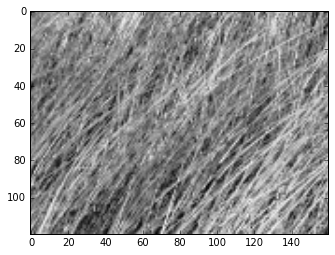

In [3]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)
sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[-0.69202207 -0.33728198 -1.24244061 ..., -0.58060361 -1.63538172
  -1.39232266]
 [-0.05946076 -0.23889167 -1.33391761 ..., -0.58060361 -1.31350687
   2.20405696]
 [ 0.20410645 -1.12440446 -1.19670211 ..., -0.37804055  1.74430416
   1.81997759]
 ..., 
 [-2.00985812  0.4498405  -1.01374811 ..., -0.46485329 -0.12256994
   1.08673514]
 [ 1.57465594  0.25305988 -0.69357861 ..., -0.66741635  2.00180404
  -0.27500083]
 [ 0.25681989  0.89259689  0.95300738 ..., -0.52272845  0.68211717
  -0.03058668]]


In [5]:
#kernel = GPy.kern.Linear(Q, ARD=True)
kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=1000)

In [7]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -0.97438583  |               |        
  [0 1]      |         1.18049590  |               |        
  [0 2]      |        -0.46616011  |               |        
  [0 3]      |         0.38623439  |               |        
  [0 4]      |        -0.49747108  |               |        
  [0 5]      |         1.51416882  |               |        
  [0 6]      |        -0.92516980  |               |        
  [0 7]      |        -1.43377043  |               |        
  [0 8]      |        -1.22505810  |               |        
  [0 9]      |         0.37604874  |               |        
  [ 0 10]    |         0.92024904  |               |        
  [ 0 11]    |         0.55810923  |               |        
  [ 0 12]    |         0.29428628  |               |        
  [ 0 13]    |         2.23099784  |               |        
  [ 0 14]    |        -1.34222560  |               |        
  [ 0 15]    |        -1

In [8]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.98672185  0.45902795  0.29208018 ...,  0.03986798  0.05259083
   0.05197302]
 [ 0.45902795  1.01396756  0.49260986 ...,  0.03558385  0.05290222
   0.05947411]
 [ 0.29208018  0.49260986  1.02564109 ...,  0.03985312  0.05878279
   0.0662588 ]
 ..., 
 [ 0.03986798  0.03558385  0.03985312 ...,  0.94078857  0.24027992
   0.07941899]
 [ 0.05259083  0.05290222  0.05878279 ...,  0.24027992  0.93590943
   0.25239164]
 [ 0.05197302  0.05947411  0.0662588  ...,  0.07941899  0.25239164
   0.9354444 ]]


In [9]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    R = np.random.multivariate_normal(meann,cov)
    
    return R

In [10]:
N_synt = 10
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[ 0.39449648  0.57450502  2.07515943 -0.25270628  1.00142043 -0.53396243
  -0.61328673  0.57561506 -0.12472001  0.31427996  1.05929118  0.69890296
   0.12398496 -1.00956211 -1.18053597  0.6538834  -0.53100489  0.77536285
  -0.98038152 -1.33150006]
 [-1.75831711  0.40871301  1.17294763  1.03087186  0.3396778  -0.86482451
  -2.67733784 -0.21846202 -0.05079877 -0.56376273 -0.06386451 -0.25268484
  -0.29642026  1.30874458 -0.68797154  1.07765238  0.40816458 -0.19873277
   0.37232932  0.52528825]
 [-2.06987695  1.62591664 -0.56878788  1.26922025  0.36308983 -0.75890868
  -2.47356975 -0.30230314  0.12220785 -0.4512546  -0.25439204  0.04856476
   0.75653347  0.32181641  1.16666242  1.37172187  0.10393928  0.18150053
  -1.89117428 -0.01745297]
 [-0.01173949  2.142906   -0.03300236  0.65359997 -0.83339397 -0.95710836
   0.18526173  1.29240052 -0.01348494  0.97173932 -0.69776534 -0.79774786
  -1.68315318 -0.41416691  0.43636118  3.40734033 -1.40183989 -1.13109375
  -0.74669023 -0.95451779]
 [ 0

In [11]:
def reconstruct_new_frame(N,X,Y,kern,Ky_inv,X_synt_i):
    
    k_y = kern.K(X,X_synt_i)
    k_yy = kern.K(X_synt_i,X_synt_i)

    meann = np.matmul(np.matmul(np.transpose(Y),Ky_inv),k_y).flatten()
    cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y)) * np.eye(D)
    
    R = np.random.multivariate_normal(meann,cov)
    
    return R

In [12]:
Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)

for i in range(N_synt):
    Y_synt[i,:] = reconstruct_new_frame(N,X,sample,kernel2,Ky_inv,X_synt[i,:].reshape(1,Q))
    
print(Y_synt)
print(np.size(Y_synt))

MemoryError: 